# **Algorithmic Methods for Data Mining: Homework 4**

**Author:** Roberto Magno Mazzotta , Gabriel Pinos

*MSc. in Data Science, Sapienza University of Rome*


## **0. Uploading the Classes and Modules**

Before doing any kind of analysis it is necessary to upload both the relevant Classes and Modules we will use to work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to datasets
path = "/Users/roberto/Desktop/HM4-ADM/datasets"
tag_df = pd.read_csv(f"{path}/tag.csv")
rating_df = pd.read_csv(f"{path}/rating.csv")
movie_df = pd.read_csv(f"{path}/movie.csv")
link_df = pd.read_csv(f"{path}/link.csv")
genome_scores_df = pd.read_csv(f"{path}/genome_scores.csv")
genome_tags_df = pd.read_csv(f"{path}/genome_tags.csv")



## **1. Recommendation System**

In this homework, we were asked to implement our version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input a user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

### **1.1. The Dataset**

We were provided with a [dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=rating.csv) that describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. 

It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.


The data are contained in six files.


- **tag.csv**: contains tags applied to movies by users:
    >- userId
    >- movieId
    >- tag
    >- timestamp

- **rating.csv**: contains ratings of movies by users:
    >- userId
    >- movieId
    >- rating
    >- timestamp

- **movie.csv**: contains movie information:
    >- movieId
    >- title
    >- genres

- **link.csv**: contains identifiers that can be used to link to other sources:
    >- movieId
    >- imdbId
    >- tmbdId

- **genome_scores.csv**: contains movie-tag relevance data:
    >- movieId
    >- tagId
    >- relevance
- **genome_tags.csv**: contains tag descriptions:
    >- tagId
    >- tag



In [2]:
# Inspect datasets
display("Tags Dataset:\n", tag_df.head())
display("Ratings Dataset:\n", rating_df.head())
display("Movies Dataset:\n", movie_df.head())
display("Links Dataset:\n", link_df.head())
display("Genome Scores Dataset:\n", genome_scores_df.head())
display("Genome Tags Dataset:\n", genome_tags_df.head())

'Tags Dataset:\n'

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


'Ratings Dataset:\n'

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


'Movies Dataset:\n'

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


'Links Dataset:\n'

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


'Genome Scores Dataset:\n'

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


'Genome Tags Dataset:\n'

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


## Preprocess the dataset 

In [3]:
import pandas as pd

# Preprocess Tags
tag_df['tag'] = tag_df['tag'].fillna('No Tag')  # Fill missing tags
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])  # Convert timestamp to datetime

# Preprocess Ratings
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])  # Convert timestamp to datetime

# Preprocess Movies
movie_df['genres'] = movie_df['genres'].fillna('Unknown')  # Fill missing genres
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)  # Extract year
movie_df['genres'] = movie_df['genres'].str.split('|')  # Split genres into lists

# Preprocess Links
link_df = link_df.fillna(0)  # Fill missing external IDs

# Preprocess Genome Scores
genome_scores_df = genome_scores_df.fillna(0)  # Fill missing values

# Preprocess Genome Tags
genome_tags_df['tag'] = genome_tags_df['tag'].fillna('No Tag')  # Fill missing tags

### **1.2 Minhash Signatures**

As a next step, we were asked to use the **userId** and **movieId**  column to try to implement min-hash signatures in order that users with similar interests in a genre appear in the same bucket. To do this we used the custom-made `minHash` class we built specifically for this homework. For more information on the **implementation** of the code behind it, please refer to the `lsh_functions` file included in the `libs` folder of this repository.

We can initialize our class:

In [4]:
# Import necessary functions
from libs.lsh_functions import ( 
    create_characteristic_matrix, 
    generate_minhash_signatures, 
    compute_jaccard_similarity, 
    compute_similarities, 
    recommend_movies, 
    plot_probability_curve, 
    visualize_signature_matrix, 
    create_sparse_interaction_matrix, 
    generate_minhash_signatures_with_interaction
)

Now, in order to perform Minhashing, we must perform the following steps:

#### **1.2.1. Shingling**

In this case, we define each different **movieId** as a shingle and represent our users as sets of shingles. Shingles are essentially the unique identifiers (IDs) of the movies that a user has interacted with or rated.

For example, we can represent a user A as:

$$A = \{\text{movie1}, \text{movie2}, \text{movie2}, \dots\},$$

Where the set contains the movieId values corresponding to the movies that the user  A  has watched or rated.

This representation captures the set of movies associated with each user, which is the fundamental input for building the characteristic matrix and applying MinHashing.

We can extract the movie shingles for every user in our dataset. For example, user 1 can be represented by their movie shingles as follows:

In [5]:
user_movies = rating_df.groupby('userId')['movieId'].apply(list)
print(f"Movies watched by User 1: {user_movies[1]}")

Movies watched by User 1: [2, 29, 32, 47, 50, 112, 151, 223, 253, 260, 293, 296, 318, 337, 367, 541, 589, 593, 653, 919, 924, 1009, 1036, 1079, 1080, 1089, 1090, 1097, 1136, 1193, 1196, 1198, 1200, 1201, 1208, 1214, 1215, 1217, 1219, 1222, 1240, 1243, 1246, 1249, 1258, 1259, 1261, 1262, 1266, 1278, 1291, 1304, 1321, 1333, 1348, 1350, 1358, 1370, 1374, 1387, 1525, 1584, 1750, 1848, 1920, 1967, 1994, 1997, 2021, 2100, 2118, 2138, 2140, 2143, 2173, 2174, 2193, 2194, 2253, 2288, 2291, 2542, 2628, 2644, 2648, 2664, 2683, 2692, 2716, 2761, 2762, 2804, 2872, 2918, 2944, 2947, 2959, 2968, 3000, 3030, 3037, 3081, 3153, 3265, 3438, 3476, 3479, 3489, 3499, 3889, 3932, 3996, 3997, 4011, 4027, 4105, 4128, 4133, 4226, 4306, 4446, 4467, 4571, 4720, 4754, 4878, 4896, 4911, 4915, 4941, 4980, 4993, 5026, 5039, 5040, 5146, 5171, 5540, 5679, 5797, 5816, 5898, 5952, 5999, 6093, 6242, 6333, 6502, 6539, 6754, 6755, 6774, 6807, 6834, 6888, 7001, 7045, 7046, 7153, 7164, 7247, 7387, 7389, 7438, 7449, 7454, 7482

In [6]:
# Merge rating_df with movie_df to include movie titles
merged_df = pd.merge(rating_df, movie_df, on='movieId')

# Display the first few rows
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",1995.0
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"[Mystery, Sci-Fi, Thriller]",1995.0
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",1995.0
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1995.0


Here we can see that the movies watched by each user (e.g., User `1`) are represented by their unique `movieId` values. This gives us insight into the specific movies a user has interacted with. We can do this for every user and represent each individual user by the set of `movieId`s they have rated or interacted with. However, to effectively compare users, we need to represent them in a way that accounts for all possible movies regardless of the order in which they appear.

###  **Building the Characteristic Matrix**

Once we've represented each of our users using their `movieId` shingles, we can construct the **characteristic matrix** for users. In this matrix:

- Each **column** corresponds to a unique user (`userId`).
- Each **row** corresponds to a unique movie (`movieId`) from the universal set of movies that appear in the dataset.

The value in the element  $(i, j)$  of the matrix is 1  if the movie in row $i$  has been rated or interacted with by the user in column $j$ ; otherwise, it is  0. The resulting matrix looks like this:

<br>

$$
\begin{pmatrix}
& \text{User ID 1}&\text{User ID 2}&\dots&\text{User $ID(n-1)$}&\text{User ID $n$}\\
\text{Movie ID 1} &1&0&\dots&0&1\\
\text{Movie ID 2} &0&0&\dots&1&0\\
\vdots &0&1&\dots&0&1\\
\text{Movie ID $m-1$} &1&0&\dots&1&1\\
\text{Movie ID $m$} &0&0&\dots&1&0
\end{pmatrix}
$$

<br>

For example, the first row represents **Movie 1**, and we can see that Users  1  and $n$  have interacted with this movie, while the others have not. Similarly, other rows correspond to different movies, and columns represent the one-hot encoded interaction of users with those movies.

We can think of this matrix as the **one-hot representation** of users based on the movies they have interacted with. This representation is critical for computing MinHash signatures.

For completeness, we can extract the column of this matrix for a specific user, such as User `1`, which gives the binary interaction vector of that user with the movies:


In [7]:
# Create a binary interaction matrix
interaction_matrix = pd.pivot_table(
    merged_df, 
    values='rating', 
    index='movieId', 
    columns='userId', 
    aggfunc=lambda x: 1,  # Use 1 to indicate interaction
    fill_value=0          # Fill with 0 for no interaction
)

interaction_matrix.head()

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_4022/2151508797.py:2: PerformanceWarning: The following operation may generate 3703856792 cells in the resulting pandas object.
  interaction_matrix = pd.pivot_table(


userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,1,0,1
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from libs.lsh_functions import create_sparse_interaction_matrix

# Convert interaction matrix to sparse matrix
sparse_interaction_matrix = create_sparse_interaction_matrix(interaction_matrix)

In [9]:
from libs.lsh_functions import next_prime, generate_minhash_signatures_with_interaction

# Define parameters for MinHash
n_hashes = 100
a_values = np.random.randint(1, next_prime(interaction_matrix.shape[0]), size=n_hashes)
b_values = np.random.randint(0, next_prime(interaction_matrix.shape[0]), size=n_hashes)

# Generate MinHash signatures
signature_matrix = generate_minhash_signatures_with_interaction(
    sparse_interaction_matrix, n_hashes, a_values, b_values
)

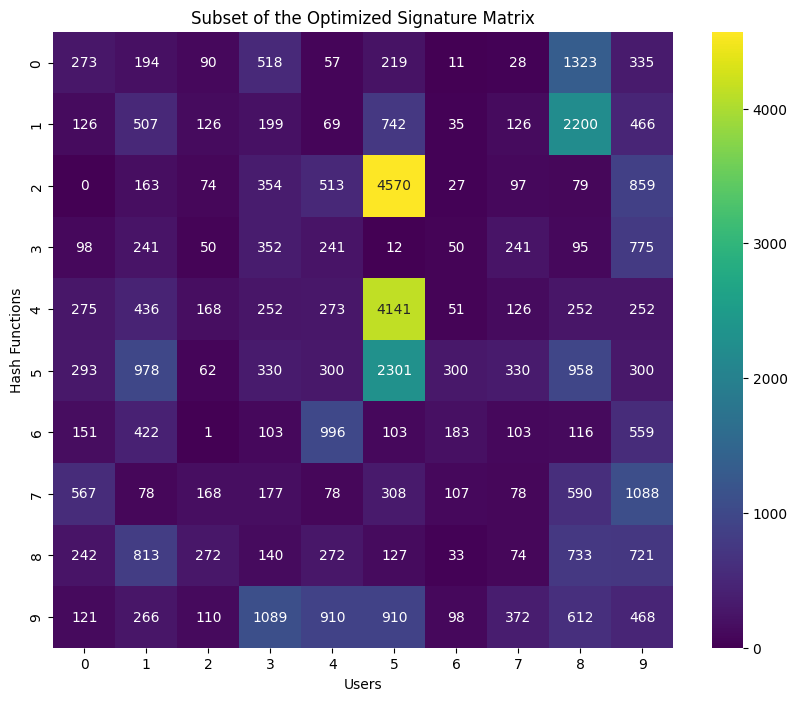

In [10]:
from libs.lsh_functions import plot_signature_matrix, plot_hash_param_effects

# Visualize the first 10x10 portion of the signature matrix
plot_signature_matrix(signature_matrix, rows=10, cols=10)

# Analyze the effect of hash function parameters
#plot_hash_param_effects(n_hashes=100, movie_range=range(1, interaction_matrix.shape[0]))

As we can see, we only have 1 values in certain indexes representing the movies the user has rated. These correspond to the specific `movieId`s the user interacted with. Using this representation, we can compare users based on their rated movies. However, as the number of users and movies grows, this representation becomes inefficient due to the sparsity of the matrix. 

To address this issue, we replace the large characteristic matrix with a smaller **signature matrix** that still preserves the underlying similarity between users.

### **Min-Hashing**

We achieve this by building a **signature matrix** using **Min-Hashing**. To create this matrix from the characteristic matrix, we follow these steps:

1. **Randomly permute the rows** of the characteristic matrix. For example, rows `12345` might become `35421`, so if "Movie A" was in row 1, it would now be in row 5.

2. For each user (i.e., column), **find the position of the first non-zero value** (indicating a rated movie) in the permuted rows. This position is used to represent the user's interaction for that permutation.

3. **Repeat this process** as many times as desired, appending each result to the user's signature vector.

Instead of explicitly permuting the rows (which is computationally expensive), we use **hash functions** to simulate the permutation process. A hash function for an input integer $x$ is defined as:

$$
h(x) = (ax + b) \mod c
$$

where:
- $a$ and $b$ are random integers less than the number of rows of the matrix.
- $c$ is a **prime number** slightly larger than the number of rows.

This approach avoids true permutations and computes the hash values directly. While this may result in hash collisions (where two rows map to the same value), the effect can be minimized by choosing appropriate values for $a$, $b$, and $c$.

Using this framework, our algorithm proceeds as follows:

1. Initialize the **signature matrix** with all values set to $\infty$.

2. For each row, compute $h_1(r), h_2(r), \dots, h_n(r)$ for $n$ random hash functions.

3. For each column $c$ of row $r$:
    - If $c$ has a $0$ in row $r$, skip it.
    - If $c$ has a $1$ in row $r$, update $S(i, c)$ for each $i \in \{1, \dots, n\}$ to be the **minimum** of the current value of $S(i, c)$ and $h_i(r)$.

The resulting **signature matrix** has dimensions determined by the number of hash functions (or permutations) and the number of users.

For our Recommendation System, we chose **100 hash functions**, so the resulting signature matrix has dimensions:

'Shape of the signature matrix:'

(100, 5)

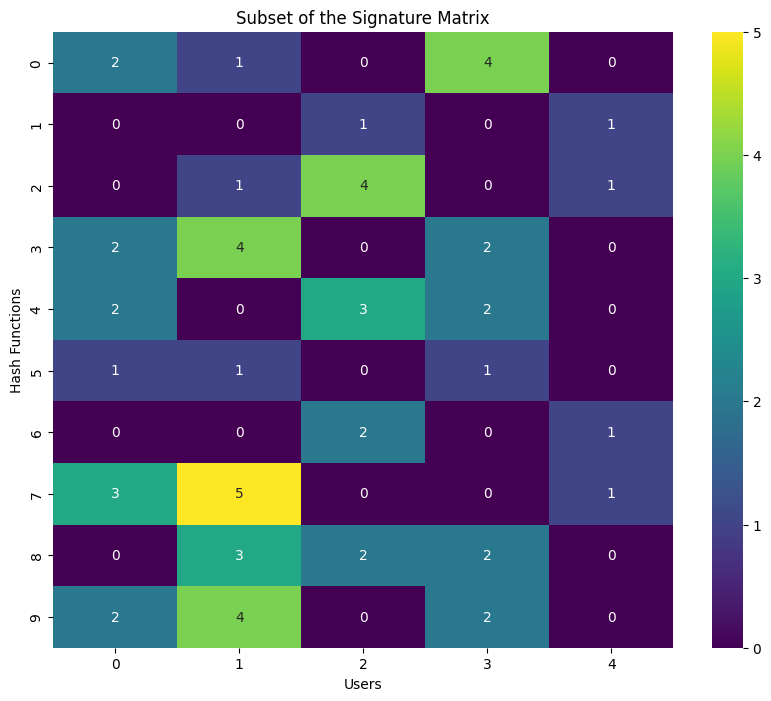

In [11]:
# Import the custom functions from your library
from libs.lsh_functions import create_characteristic_matrix, generate_minhash_signatures, next_prime, visualize_signature_matrix


# A dictionary where keys are user IDs and values are sets of movie IDs watched by the user
user_movies = {
    1: {1, 2, 3},
    2: {3, 4},
    3: {5, 6},
    4: {1, 3, 5},
    5: {2, 4, 6}
}

# All movies in the dataset
all_movies = {1, 2, 3, 4, 5, 6}

# Create the characteristic matrix
characteristic_matrix = create_characteristic_matrix(None, all_movies, user_movies)

# Generate MinHash signatures with a specified number of hash functions
n_hashes = 100
signature_matrix = generate_minhash_signatures(characteristic_matrix, n_hashes)

# Obtain the shape of the signature matrix
display("Shape of the signature matrix:", signature_matrix.shape)

# Visualize the first 10 rows and columns of the signature matrix using a heatmap
visualize_signature_matrix(signature_matrix, rows=10, cols=10)

---

Through this method, we produce vectors of equal length that contain positive integer values representing the MinHash signatures for each user, based on the movies they have rated. These signatures allow us to approximate user similarity efficiently. Ideally, we want to hash users into **buckets** such that users with similar preferences (based on their movie lists) end up in the same bucket. However, if we hash based on the entire signature as a whole, only identical signatures would end up in the same bucket, which is not practical for approximate similarity searches.

In most cases, even though parts of two signatures may match, they might still be hashed into separate buckets. This is undesirable because it prevents us from identifying partially similar users. To address this, we use the **banding** technique.

#### **Banding and Bucketing**

The banding method addresses this issue by splitting the MinHash signature matrix into smaller sub-vectors called *bands*. Instead of hashing the entire signature for a user into a single bucket, we hash each band independently. For instance, splitting a 100-dimensional signature into 20 bands results in 20 opportunities to match users based on their sub-vector similarity.

While this increases the chance of false positives (users hashed into the same bucket despite being dissimilar), we can tune the trade-off by adjusting the number of bands (\(b\)) and the number of rows per band \($r$\). The probability of a pair of users being hashed into the same bucket given their Jaccard similarity \($s$\) is:

$$
\mathbb{P} = 1 - (1 - s^r)^b,
$$

where:

- \($b$)\: Number of bands (splits in the signature matrix).
- \($r$)\: Number of rows per band:
$$r = \frac{\text{signature length}}{b}$$


The **Jaccard Similarity** between users refers to the similarity between the sets of movies they have rated. We can visualize the effect of different banding configurations by plotting this probability for varying values of \($b$\):

```python
# Plot the probability of users being hashed into the same bucket as a function of their similarity
plot_probability_curve(n=100, band_values=[5, 20, 25, 50]) 

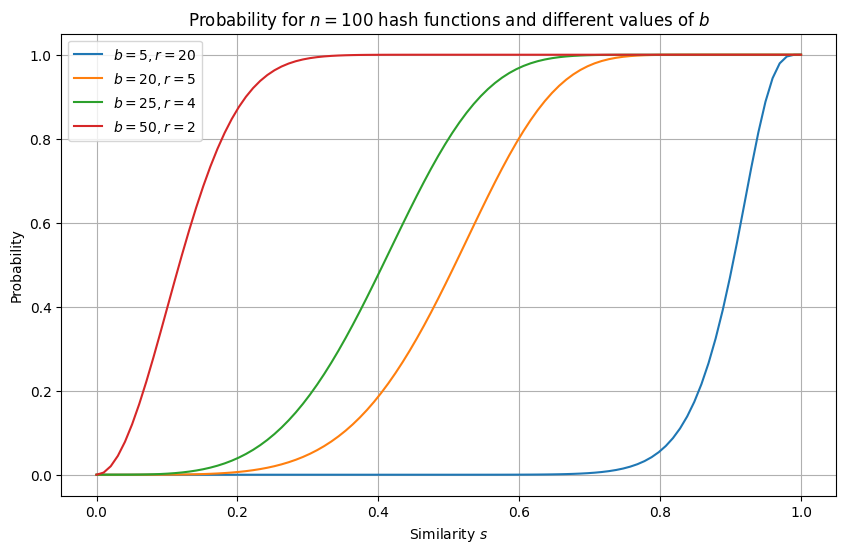

In [12]:
# Example: Plot the probability curve
plot_probability_curve(n=100, band_values=[5, 20, 25, 50])

### **Probability Plot for MinHash Banding**

This visualization shows the **probability of two users being hashed into the same bucket** as a function of their similarity $s$, based on different banding configurations in the MinHash algorithm.

#### **Key Aspects**

1. **Hash Functions ($n = 100$)**:
   - The total number of hash functions used to generate the MinHash signatures is fixed at $n = 100$.

2. **Banding Parameter ($b$)**:
   - The curves represent different values of $b$ (number of bands).
   - For example:
     - $b = 5$: Larger number of rows per band ($r = n / b = 20$).
     - $b = 50$: Smaller number of rows per band ($r = n / b = 2$).

3. **Trade-off Between $b$ and $r$**:
   - **Fewer bands ($b$) and more rows per band ($r$)**:
     - The curve is steeper, requiring higher similarity for users to be hashed to the same bucket.
     - Reduces false positives but increases false negatives.
   - **More bands ($b$) and fewer rows per band ($r$)**:
     - The curve is smoother, allowing even lower similarity pairs to hash into the same bucket.
     - Increases false positives but reduces false negatives.

4. **Interpretation of Similarity $s$**:
   - $s = 0$: Probability is $0$, meaning users with no similarity will not hash to the same bucket.
   - $s = 1$: Probability is $1$, meaning users with identical signatures will always hash to the same bucket.
   - Intermediate $s$ values (e.g., $s = 0.4, 0.6$): The probability increases as similarity grows, depending on $b$ and $r$.

5. **Use Case**:
   - This plot helps determine the optimal $b$ and $r$ configuration based on the desired trade-off between false positives and false negatives.

#### **Probability Formula**:
The probability of a pair of users being hashed into the same bucket is given by:
$$
\mathbb{P} = 1 - (1 - s^r)^b
$$
where:
- $b$: Number of bands.
- $r$: Number of rows per band $\left(r = \frac{\text{signature length}}{b}\right)$.

#### **Recommendation**
- For applications that require **high precision** (fewer false positives), choose configurations with fewer bands ($b = 5$ or $b = 10$).
- For applications that tolerate **false positives** but emphasize capturing similar users, choose configurations with more bands ($b = 25$ or $b = 50$).

---


In [18]:
from libs.lsh_functions import lsh_bucket_creation, find_similar_users, recommend_movies_lsh

In [14]:
# Create LSH buckets
n_bands = 20  # Number of bands
buckets = lsh_bucket_creation(signature_matrix, n_bands)

# Debugging: Display a few buckets and their contents
print("=== Debug: LSH Buckets ===")
for band_hash, users in list(buckets.items())[:10]:  # Display first 10 buckets
    print(f"Band Hash: {band_hash} -> Users: {users}")

=== Debug: LSH Buckets ===
Band Hash: (np.int64(2), np.int64(0), np.int64(0), np.int64(2), np.int64(2)) -> Users: [0]
Band Hash: (np.int64(1), np.int64(0), np.int64(1), np.int64(4), np.int64(0)) -> Users: [1]
Band Hash: (np.int64(0), np.int64(1), np.int64(4), np.int64(0), np.int64(3)) -> Users: [2]
Band Hash: (np.int64(4), np.int64(0), np.int64(0), np.int64(2), np.int64(2)) -> Users: [3]
Band Hash: (np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)) -> Users: [4, 4, 3]
Band Hash: (np.int64(1), np.int64(0), np.int64(3), np.int64(0), np.int64(2)) -> Users: [0]
Band Hash: (np.int64(1), np.int64(0), np.int64(5), np.int64(3), np.int64(4)) -> Users: [1]
Band Hash: (np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(0)) -> Users: [2]
Band Hash: (np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(2)) -> Users: [3]
Band Hash: (np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(3)) -> Users: [0]


In [19]:
####changed :::

# Adjusted Bucket Creation with Better Parameter Selection
n_hashes = signature_matrix.shape[0]
target_rows_per_band = 5  # Target rows per band
n_bands = n_hashes // target_rows_per_band  # Adjust number of bands dynamically

buckets = lsh_bucket_creation(signature_matrix, n_bands)

# Debugging: Display the first 10 buckets to verify grouping
print("=== Debug: Updated LSH Buckets ===")
for band_hash, users in list(buckets.items())[:10]:
    print(f"Band Hash: {band_hash} -> Users: {users}")

=== Debug: Updated LSH Buckets ===
Band Hash: (np.int64(2), np.int64(0), np.int64(0), np.int64(2), np.int64(2)) -> Users: [0]
Band Hash: (np.int64(1), np.int64(0), np.int64(1), np.int64(4), np.int64(0)) -> Users: [1]
Band Hash: (np.int64(0), np.int64(1), np.int64(4), np.int64(0), np.int64(3)) -> Users: [2]
Band Hash: (np.int64(4), np.int64(0), np.int64(0), np.int64(2), np.int64(2)) -> Users: [3]
Band Hash: (np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)) -> Users: [4, 4, 3]
Band Hash: (np.int64(1), np.int64(0), np.int64(3), np.int64(0), np.int64(2)) -> Users: [0]
Band Hash: (np.int64(1), np.int64(0), np.int64(5), np.int64(3), np.int64(4)) -> Users: [1]
Band Hash: (np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(0)) -> Users: [2]
Band Hash: (np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(2)) -> Users: [3]
Band Hash: (np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(3)) -> Users: [0]


In [20]:
### modifiedd

def find_most_similar_users(user_idx, buckets):
    """
    Identify the two most similar users for a given user based on bucket placement.
    Args:
        user_idx: Index of the target user.
        buckets: Buckets from LSH.
    Returns:
        most_similar_users: List of up to 2 user indices that are most similar to the target user.
    """
    similar_users = defaultdict(int)
    for band_hash, users in buckets.items():
        if user_idx in users:
            for user in users:
                if user != user_idx:
                    similar_users[user] += 1

    # Sort by the number of shared buckets (descending) and return top-2
    most_similar_users = sorted(similar_users, key=similar_users.get, reverse=True)[:2]
    return most_similar_users


In [22]:
####modfied
from collections import defaultdict

# Example: Find top-2 similar users for User 0
most_similar_users = find_most_similar_users(target_user_idx, buckets)
print(f"Top-2 similar users for User {target_user_idx + 1}: {most_similar_users}")

Top-2 similar users for User 1: [4]


In [23]:
### modified
def recommend_movies_lsh_v2(target_user_idx, user_movies, buckets, ratings, top_n=5):
    """
    Recommend movies for a target user based on the two most similar users.
    Args:
        target_user_idx: Index of the target user.
        user_movies: Dictionary mapping user indices to sets of movies they rated.
        buckets: Buckets from LSH.
        ratings: DataFrame containing user ratings (userId, movieId, rating).
        top_n: Number of recommendations to return.
    Returns:
        recommendations: List of recommended movies with predicted ratings.
    """
    # Find the top-2 similar users
    most_similar_users = find_most_similar_users(target_user_idx, buckets)
    if not most_similar_users:
        print(f"No similar users found for User {target_user_idx + 1}.")
        return []

    target_user_movies = user_movies[target_user_idx + 1]
    movie_ratings = defaultdict(list)

    # Aggregate ratings from similar users
    for similar_user_idx in most_similar_users:
        similar_user_movies = user_movies[similar_user_idx + 1]
        for movie in similar_user_movies:
            if movie not in target_user_movies:  # Exclude already rated
                user_rating = ratings[
                    (ratings["userId"] == similar_user_idx + 1) & (ratings["movieId"] == movie)
                ]["rating"].mean()
                if not np.isnan(user_rating):
                    movie_ratings[movie].append(user_rating)

    # Compute average ratings for common movies
    avg_movie_ratings = {movie: np.mean(ratings) for movie, ratings in movie_ratings.items()}

    # Sort by average rating
    sorted_movies = sorted(avg_movie_ratings.items(), key=lambda x: x[1], reverse=True)

    # Ensure at most top_n recommendations
    recommendations = sorted_movies[:top_n]
    return recommendations


In [24]:
#### modfied:::


# Example: Recommend movies for User 0
recommendations = recommend_movies_lsh_v2(
    target_user_idx=0,
    user_movies=user_movies,
    buckets=buckets,
    ratings=rating_df,
    top_n=5
)
print(f"Recommended movies for User {target_user_idx + 1}: {recommendations}")

Recommended movies for User 1: []


In [15]:
# Example: Find similar users for User 0
target_user_idx = 0
similar_users = find_similar_users(target_user_idx, buckets)
print(f"Similar users for User {target_user_idx + 1}: {similar_users}")

Similar users for User 1: {4}


In [27]:
# Example: Recommend movies for User 0
recommendations = recommend_movies_lsh(
    target_user_idx=5,
    user_movies=user_movies,
    buckets=buckets,
    ratings=rating_df,
    top_n=5
)
print(f"Recommended movies for User {target_user_idx + 1}: {recommendations}")

No similar users found for User 6.
Recommended movies for User 1: []


In [26]:
# Perform the complete LSH workflow
for user_idx in range(len(user_movies)):
    print(f"\nRecommendations for User {user_idx + 1}:")
    recommendations = recommend_movies_lsh(
        target_user_idx=user_idx,
        user_movies=user_movies,
        buckets=buckets,
        ratings=rating_df,
        top_n=5
    )
    for movie, rating in recommendations:
        print(f"Movie ID: {movie}, Predicted Rating: {rating:.2f}")


Recommendations for User 1:

Recommendations for User 2:
No similar users found for User 2.

Recommendations for User 3:
Movie ID: 2, Predicted Rating: 3.00

Recommendations for User 4:
Movie ID: 2, Predicted Rating: 3.00

Recommendations for User 5:
